# Queuing Server Demo

Introduce loads per user, have servers serve all user in parallel and return latency value. Users have latency threshold, and receive reward if latency is below threshold. 

In [1]:
cd /home/tkim/Academics/DistMEC/

/home/tkim/Academics/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [240]:
# Server Class
class Server():
    def __init__(self, rate, s_idx):
        self.rate = rate
        self.s_idx = s_idx
        
    def receive_users(self, loads_list):
        load = np.sum(loads_list)
        rate = np.random.exponential(self.rate)
        latency = load/rate
        return latency
        
# User Class - Receive Reward + Arm Selection
class User():

    def __init__(self, load, latency_threshold, num_servers,T):
        self.load = load
        self.latency_threshold = latency_threshold
        self.pulls, self.means, self.ucb_idx = np.zeros(num_servers), np.zeros(num_servers), np.zeros(num_servers)
        self.t = int(0)
        self.reward_log = np.zeros(T + num_servers)
        self.arm_history = np.zeros(T + num_servers)
        
    def calc_ucb(self):
        for i in range(self.ucb_idx.shape[0]):
            self.ucb_idx[i] = self.means[i] + np.sqrt(np.log(self.t)/self.pulls[i])
            
    def select_arm(self):
        arm_id = np.random.choice(np.flatnonzero(self.ucb_idx == self.ucb_idx.max()))
        self.arm_history[self.t] = int(arm_id)
        
        return arm_id
    
    def log_reward(self, latency):
        
        curr_reward = 0
        if latency < self.latency_threshold:
            curr_reward = 1

        self.reward_log[self.t] = curr_reward
        arm_id = int(self.arm_history[self.t])
        self.means[int(self.arm_history[int(self.t)])] = (curr_reward + self.means[int(self.arm_history[int(self.t)])] 
                                                          * self.pulls[int(arm_id)])/(self.pulls[int(arm_id)] + 1)

        self.pulls[arm_id] += 1
        self.t += int(1)
        
        return curr_reward

In [188]:
def init_offload_dict(num_svrs):
    offload_dict = {}
    for i in range(num_svrs):
        offload_dict[i] = []
    return offload_dict



In [ ]:
import numpy as np
import pulp as lp
import itertools
import copy

# Compute the optimal static allocation in this scenario
def offline_optimal_action(thresh_u, load_u, svr_rate):
    
    prob = lp.LpProblem("prob",lp.LpMaximize)
    
    # Import pulp and make decision variables
    dec_var = []
    for u,s in itertools.product(range(num_user),range(num_server)):
        dec_var += [(u,s)]
        
    X = lp.LpVariable.dicts("x", dec_var,lowBound=0,upBound = 1, cat='Integer')

    # Make Constraints - 1 pull per user
    usr_constraint = []
    for u in range(num_user):
        usr_constraint += [0]

    for u,s in itertools.product(range(num_user),range(num_server+1)):
        usr_constraint[u] += X[(u,s-1)]

    for u in range(num_user):
        prob += (usr_constraint[u] == 1)
        
    

In [270]:
# System Parameters
T = 10000
num_users = 5
num_svrs = 5

# Set user load and latency times
thresh_u = np.random.uniform(1,2,num_users)
load_u = np.random.uniform(0.5,1,num_users)
svr_rate = np.random.uniform(0.9,2, num_svrs)

thresh_u = np.random.uniform(1,1,num_users)
load_u = np.random.uniform(0.7,0.7,num_users)
svr_rate = np.random.uniform(1,1, num_svrs)

# Set up system
# Make servers and users
Servers = []
Users = []

for s in range(num_svrs):
    Servers += [Server(svr_rate[s],s)]
    
for u in range(num_users):
    Users += [User(load_u[u],thresh_u[u],num_svrs,T)]

# Calculate Optimal Reward    

# Run Bandits
rewards = np.zeros(T)

# Each user pulls each server once
for i in range(num_users):
    for s in range(num_svrs):
        lat = Servers[s].receive_users([Users[i].load])
        Users[i].log_reward(lat)
        
# Run Bandits
for t in range(T):
    
    # Users select arms
    offload_dict = init_offload_dict(num_svrs)
    load_dict = init_offload_dict(num_svrs)
    for u in range(num_users):
        arm = Users[u].select_arm()
        load = Users[u].load
        
        offload_dict[arm] += [u]
        load_dict[arm] += [load]
        
    # Offload to servers and get latency
    lat_vals = np.zeros(num_users)
    for s in range(num_svrs):
        lat = Servers[s].receive_users(load_dict[s])
        for u in offload_dict[s]:
            reward = Users[u].log_reward(lat)    
    
            rewards[t] += reward

In [234]:
num_user = num_users
num_server = num_svrs

prob = lp.LpProblem("prob",lp.LpMaximize)

# Import pulp and make decision variables
dec_var = []
for u,s in itertools.product(range(num_user),range(num_server)):
    dec_var += [(u,s)]

X = lp.LpVariable.dicts("x", dec_var,lowBound=0,upBound = 1, cat='Integer')

# Make Constraints - 1 pull per user
usr_constraint = []
for u in range(num_user):
    usr_constraint += [0]

for u,s in itertools.product(range(num_user),range(num_server)):
    usr_constraint[u] += X[(u,s)]

for u in range(num_user):
    prob += (usr_constraint[u] == 1)
    
obj = 0
for u,s in itertools.product(range(num_user),range(num_server)):
    temp_u = load_u[u]/svr_rate[s]
    for u2 in range(num_user):
        if u2 != u:
            temp_u += X[(u2,s)]*load_u[u2]/svr_rate[s] 
    obj += X[(u,s)] * (thresh_u[u] >= temp_u)
    
prob += obj

status = prob.solve(lp.PULP_CBC_CMD(msg=0))

X2 = copy.deepcopy(X)

action = np.ones_like(np.ndarray(num_users)) * -1


for key in X2.keys():
    if X2[key].value() > 0:
        u,s = key
        action[u] = s

In [235]:
action

array([0., 4., 0., 4., 4.])

In [239]:
obj

1*x_(0,_0) + 1*x_(0,_1) + 1*x_(0,_2) + 1*x_(0,_3) + 1*x_(0,_4) + 1*x_(1,_0) + 1*x_(1,_1) + 1*x_(1,_2) + 1*x_(1,_3) + 1*x_(1,_4) + 1*x_(2,_0) + 1*x_(2,_1) + 1*x_(2,_2) + 1*x_(2,_3) + 1*x_(2,_4) + 1*x_(3,_0) + 1*x_(3,_1) + 1*x_(3,_2) + 1*x_(3,_3) + 1*x_(3,_4) + 1*x_(4,_0) + 1*x_(4,_1) + 1*x_(4,_2) + 1*x_(4,_3) + 1*x_(4,_4) + 0

No handles with labels found to put in legend.


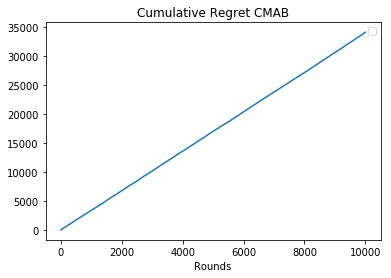

In [271]:
plot_idx = 1

plt.plot(np.cumsum(np.ones(rewards.shape) * num_user) - np.cumsum(rewards))
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.legend()

In [272]:
np.cumsum(np.ones(rewards.shape) * num_user)

array([5.0000e+00, 1.0000e+01, 1.5000e+01, ..., 4.9990e+04, 4.9995e+04,
       5.0000e+04])

In [273]:
np.mean(rewards)

1.583